In [ ]:
import pandas as pd

In [ ]:
X_train = pd.read_csv(f"/opt/ml/processing/output/train/train.csv")
X_test = pd.read_csv(f"/opt/ml/processing/output/test/test.csv")
y_train = pd.read_csv(f"/opt/ml/processing/output/train/train_labels.csv")
y_test = pd.read_csv(f"/opt/ml/processing/output/test/test_labels.csv")

In [ ]:
# Drop user_id, lock_id from all pandas dataframes

X_train = X_train.drop(['user_id', 'lock_id', 'access_granted', 'is_weekend', 'is_business_hours', 'access_level', 'failed_attempts', 'time_of_day'], axis=1)
X_test = X_test.drop(['user_id', 'lock_id', 'access_granted', 'is_weekend', 'is_business_hours', 'access_level', 'failed_attempts', 'time_of_day'], axis=1)

In [ ]:
X_train

In [ ]:
%set_env MLFLOW_TRACKING_URI=arn:aws:sagemaker:eu-central-1:559317267498:mlflow-tracking-server/mlflow-experiments
%set_env MLFLOW_EXPERIMENT_NAME=anomaly-detection
%set_env AWS_PROFILE=AWSAdministratorAccess-559317267498

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def train_PCA(X_train, y_train, X_test, y_test):
    import mlflow
    from sklearn.decomposition import PCA
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import confusion_matrix

    with mlflow.start_run(run_name="pca"):
        # Initialize and train PCA
        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Log PCA components
        print(f"PCA n components: {pca.n_components_}")
        mlflow.log_metric("pca_components", pca.n_components_)

        # Train a simple classifier (e.g., Logistic Regression)
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(random_state=42)
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # log confusion_matrix to figure and mlflow
        fig, ax = plt.subplots()
        # add legend to axes
        plt.title('Confusion Matrix', pad=20, size=14)
        s = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        s.set(xlabel='Predicted', ylabel='Actual')

        mlflow.log_figure(fig, "confusion_matrix.png")

        # Log metrics
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        })

        return pca, clf, X_train_pca, X_test_pca


In [ ]:
pca, clf, X_train_pca, X_test_pca = train_PCA(X_train, y_train, X_test, y_test)

In [ ]:
# let's use my trained logistic regression model to predict whether a datapoint is an anomaly
sample = X_test.iloc[22]
result = y_test.iloc[22]
print(f"sample {sample} with result {result}")

pca_comp = pca.transform([sample])
pred_prob = clf.predict(pca_comp)
print(pred_prob)

# PCA Visualization

This section visualizes the results of Principal Component Analysis (PCA) applied to our dataset.

## 1. Scatter Plot of Principal Components

First, we'll create a scatter plot of the first two principal components to visualize how our data points are distributed in the reduced dimensional space.

This plot helps us:

- Visualize data clustering patterns
- Identify potential outliers
- Understand data distribution in reduced dimensions

## 2. Explained Variance Ratio

Next, we'll plot the cumulative explained variance ratio to understand how much information is retained by each principal component.

This plot helps us:

- Determine the optimal number of components to retain
- Understand the trade-off between dimensionality reduction and information preservation
- Identify the point of diminishing returns in adding more components


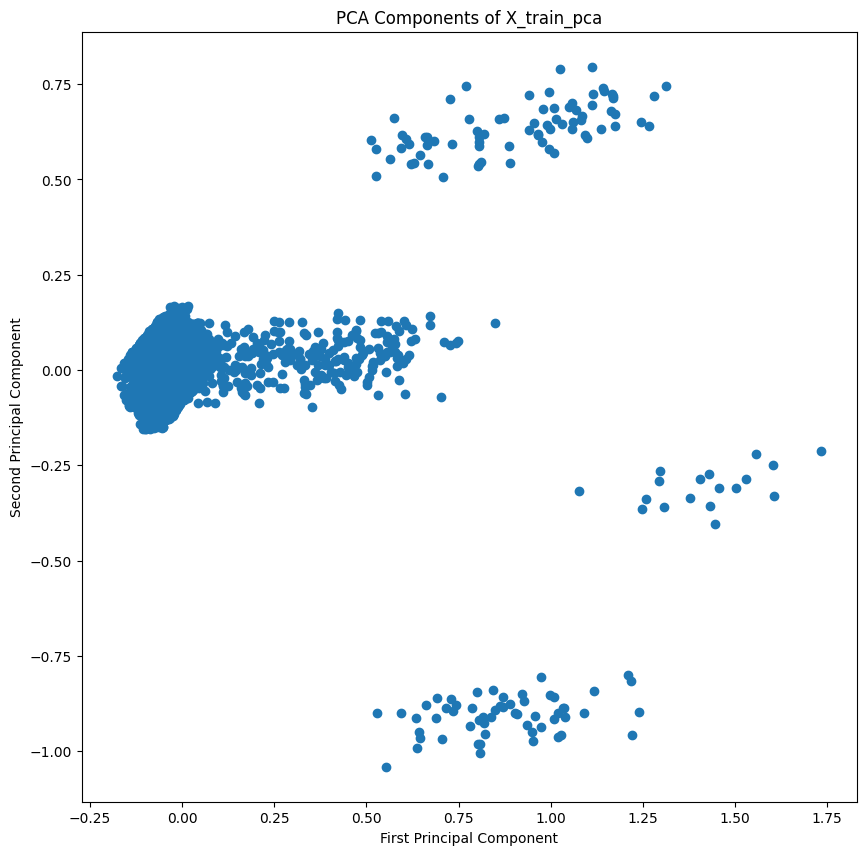

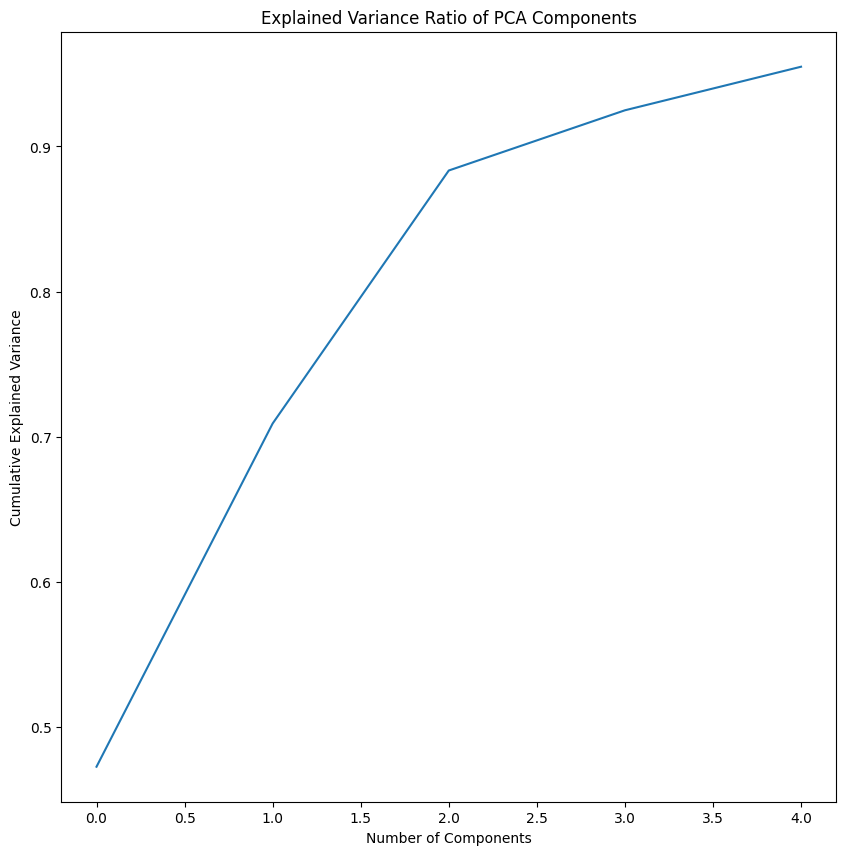

In [113]:
# Get the dimensions of the following array

import matplotlib.pyplot as plt
import numpy as np
X_train_pca.shape

# Plot the PCA components of X_train_pca

plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Components of X_train_pca')
plt.show()
# Plot the explained variance ratio of the PCA components

plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio of PCA Components')
plt.show()